[*********************100%%**********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=13026.690, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=11752.396, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=10933.714, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=10697.636, Time=0.18 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=10580.732, Time=0.26 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=10436.931, Time=0.31 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=10278.710, Time=0.35 sec
 ARIMA(7,2,0)(0,0,0)[0]             : AIC=10255.016, Time=0.46 sec
 ARIMA(8,2,0)(0,0,0)[0]             : AIC=10165.409, Time=0.51 sec
 ARIMA(9,2,0)(0,0,0)[0]             : AIC=10088.024, Time=0.59 sec
 ARIMA(10,2,0)(0,0,0)[0]             : AIC=10027.592, Time=0.57 sec
 ARIMA(11,2,0)(0,0,0)[0]             : AIC=9985.933, Time=0.66 sec
 ARIMA(12,2,0)(0,0,0)[0]             : AIC=9949.199, Time=0.73 sec
 ARIMA(13,2,0)(0,0,0)[0]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frederik135. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | model     | LSTMModel | 10.7 K
1 | criterion | MSELoss   | 0     
----------------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)


c:\Users\janfr\anaconda3\envs\pytorch_3_10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\janfr\anaconda3\envs\pytorch_3_10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 149: 100%|██████████| 67/67 [00:00<00:00, 137.41it/s, v_num=mrv7, train_loss_step=0.00247, val_loss_step=1.280, val_loss_epoch=0.221, train_loss_epoch=0.00148]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 67/67 [00:00<00:00, 77.71it/s, v_num=mrv7, train_loss_step=0.00247, val_loss_step=1.280, val_loss_epoch=0.221, train_loss_epoch=0.00148] 

Restoring states from the checkpoint path at .\RNN_single_step_forecasts\v3swmrv7\checkpoints\epoch=149-step=10050.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at .\RNN_single_step_forecasts\v3swmrv7\checkpoints\epoch=149-step=10050.ckpt
c:\Users\janfr\anaconda3\envs\pytorch_3_10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 302.75it/s]

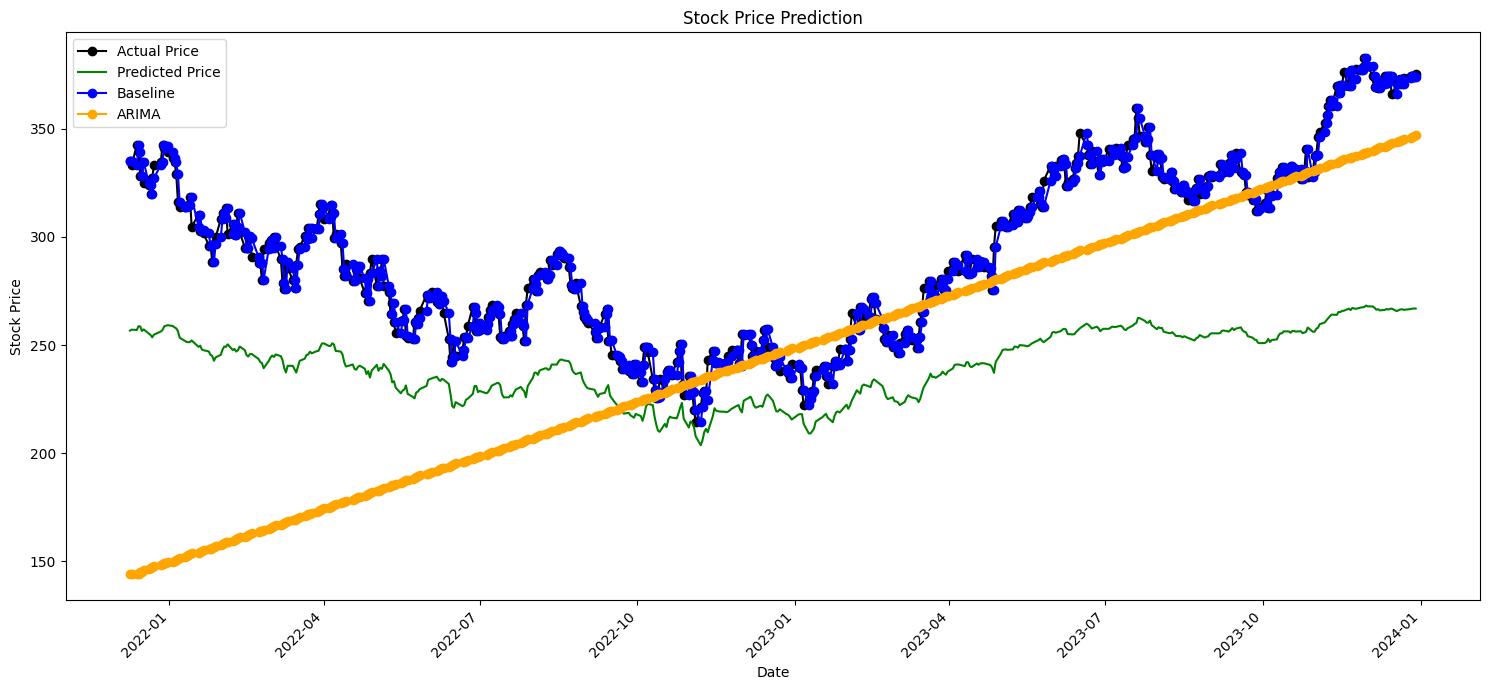

Testing DataLoader 0: 100%|██████████| 9/9 [00:01<00:00,  6.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7950005531311035
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
train_loss_epoch,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▁▁▁▃▃▁▁▁▁▄▄▁▁▁▁▁▂▂▅▅▂▂▂▂▆▇▇▂▂▂▂▂▂█
val_loss_epoch,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,█▂▇▂▆▂▁▂▅▁▁▂▁▂▁▄▁▂▁▃▁▃▁▁▁▃▁▁▂▁▂▁▁▁▁▁▃▁▂▁
epoch,150
test_loss,0.795
train_loss_epoch,0.00148
train_loss_step,0.00247


In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import wandb
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from models import RNNModel, LSTMModel, GRUModel
from config import stock_ticker, architecture, seq_length, start_date, end_date, num_epochs, learning_rate, wandb_config, model_config


class StockPredictionModule(pl.LightningModule):
    def __init__(self, model, scaler, train_loader, val_loader, test_loader, test_dates, arima_results):
        super().__init__()
        self.model = model
        self.scaler = scaler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.test_dates = test_dates
        self.arima_results = arima_results
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self):
        predictions, actuals = [], []
        for seqs, labels in self.test_loader:
            seqs, labels = seqs.to(self.device), labels.to(self.device)
            output = self(seqs)
            predictions.extend(output.view(-1).tolist())
            actuals.extend(labels.view(-1).tolist())
        
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        predictions_original_scale = list(self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten())
        actuals_original_scale = list(self.scaler.inverse_transform(actuals.reshape(-1, 1)).flatten())
        baseline_original_scale = [actuals_original_scale[0]] + actuals_original_scale[:-1]
        arima_predictions = self.arima_results.predict(n_periods=len(actuals_original_scale))

        
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(self.test_dates, actuals_original_scale, label='Actual Price', color='black', linestyle='-', marker='o')
        ax.plot(self.test_dates, predictions_original_scale, label='Predicted Price', color='green', linestyle='-')
        ax.plot(self.test_dates, baseline_original_scale, label='Baseline', color='blue', linestyle='-', marker='o')
        ax.plot(self.test_dates, arima_predictions, label='ARIMA', color='orange', linestyle='-', marker='o')
        ax.set_title('Stock Price Prediction')
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.legend()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.plot()
        plt.show()
        
        filename = "plot.png"
        fig.savefig(filename)
        wandb.log({"Stock Price Prediction": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        actuals_original_scale = np.array(actuals_original_scale)
        predictions_original_scale = np.array(predictions_original_scale)
        baseline_original_scale = np.array(baseline_original_scale)

        model_mse = mean_squared_error(actuals_original_scale, predictions_original_scale)
        model_rmse = np.sqrt(model_mse)
        model_mae = mean_absolute_error(actuals_original_scale, predictions_original_scale)
        model_r2 = r2_score(actuals_original_scale, predictions_original_scale)
        model_mape = np.mean(np.abs((actuals_original_scale - predictions_original_scale) / actuals_original_scale))
        
        baseline_mse = mean_squared_error(actuals_original_scale, baseline_original_scale)
        baseline_rmse = np.sqrt(baseline_mse)
        baseline_mae = mean_absolute_error(actuals_original_scale, baseline_original_scale)
        baseline_r2 = r2_score(actuals_original_scale, baseline_original_scale)
        baseline_mape = np.mean(np.abs((actuals_original_scale - baseline_original_scale) / (actuals_original_scale + 1e-8)))

        arima_mse = mean_squared_error(actuals_original_scale, arima_predictions)
        arima_rmse = np.sqrt(arima_mse)
        arima_mae = mean_absolute_error(actuals_original_scale, arima_predictions)
        arima_r2 = r2_score(actuals_original_scale, arima_predictions)
        arima_mape = np.mean(np.abs((actuals_original_scale - arima_predictions) / actuals_original_scale))

        model_metrics = {
            "mse": model_mse,
            "rmse": model_rmse,
            "mae": model_mae,
            "mape": model_mape,
            "r2": model_r2,
        }

        baseline_metrics = {
            "mse": baseline_mse,
            "rmse": baseline_rmse,
            "mae": baseline_mae,
            "mape": baseline_mape,
            "r2": baseline_r2,
        }

        arima_metrics = {
            "mse": arima_mse,
            "rmse": arima_rmse,
            "mae": arima_mae,
            "mape": arima_mape,
            "r2": arima_r2,
        }

        model_baseline_performance_metrics = {
            "mse": round((baseline_mse / model_mse - 1) * 100, 2),
            "rmse": round((baseline_rmse / model_rmse - 1) * 100, 2),
            "mae": round((baseline_mae / model_mae - 1) * 100, 2),
            "mape": round((baseline_mape / model_mape - 1) * 100, 2),
            "r2": round((model_r2 / baseline_r2 - 1) * 100, 2),
        }

        model_arima_performance_metrics = {
            "mse": round((arima_mse / model_mse - 1) * 100, 2),
            "rmse": round((arima_rmse / model_rmse - 1) * 100, 2),
            "mae": round((arima_mae / model_mae - 1) * 100, 2),
            "mape": round((arima_mape / model_mape - 1) * 100, 2),
            "r2": round((model_r2 / arima_r2 - 1) * 100, 2),
        }

        metrics_table = wandb.Table(columns=["metric", "model", "baseline", "arima", "model-baseline performance comparison [%]", "model-arima performance comparison [%]"])

        for metric in model_metrics.keys():
            metrics_table.add_data(metric, model_metrics[metric], baseline_metrics[metric], arima_metrics[metric], 
                                   model_baseline_performance_metrics[metric], model_arima_performance_metrics[metric])

        wandb.log({"metrics": metrics_table})


def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        xs.append(data[i:(i+seq_length)])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)


def load_data():
    stock_df = yf.download(stock_ticker, start=start_date, end=end_date)

    split_idx = int(len(stock_df) * 0.8) + seq_length
    train_df = stock_df.iloc[:split_idx]
    temp_df = stock_df.iloc[split_idx:]

    train_actual_prices = train_df['Close'].values
    # p: autoregression (number of lag observations included in the model), q: moving average, d: degree of differencing; 
    auto_arima_model = auto_arima(train_actual_prices, start_p=0, start_q=0, max_p=15, max_q=15, max_d=5, 
                                  trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_normalized = scaler.fit_transform(train_df[['Close']].values.reshape(-1, 1))
    X_train, y_train = create_sequences(train_normalized, seq_length)

    temp_normalized = scaler.transform(temp_df[['Close']].values.reshape(-1, 1))
    X_temp, y_temp = create_sequences(temp_normalized, seq_length)

    split_idx_temp = len(y_temp) // 2
    X_val, X_test = X_temp[:split_idx_temp], X_temp[split_idx_temp:]
    y_val, y_test = y_temp[:split_idx_temp], y_temp[split_idx_temp:]

    test_dates = stock_df.index[-(len(X_test) + seq_length):].tolist()
    test_dates = test_dates[seq_length:]

    train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=False)
    val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False)

    return train_loader, val_loader, test_loader, scaler, test_dates, auto_arima_model


def main():

    torch.set_float32_matmul_precision("medium")
    wandb_logger = WandbLogger(project="RNN_single_step_forecasts", log_model="all", config=wandb_config)

    train_loader, val_loader, test_loader, scaler, test_dates, auto_arima_model = load_data()

    if architecture == "RNN":
        model = RNNModel(**model_config)
    elif architecture == "LSTM":
        model = LSTMModel(**model_config)
    elif architecture == "GRU":
        model = GRUModel(**model_config)
    else:
        raise ValueError("Unsupported architecture specified")

    module = StockPredictionModule(model=model, scaler=scaler, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, 
                                   test_dates=test_dates, arima_results=auto_arima_model)

    # Device agnostic initialization
    if torch.cuda.is_available():   # Check for GPU availability
        accelerator = "gpu"
        devices = 1
    elif hasattr(torch, 'has_mps') and torch.backends.mps.is_built():  # Check for MPS availability (Apple Silicon)
        accelerator = "mps"
        devices = 1
    else:
        accelerator = None  # Defaults to CPU
        devices = None  # Ignored for CPU

    trainer = Trainer(max_epochs=num_epochs, logger=wandb_logger, accelerator=accelerator, devices=devices, enable_checkpointing=True)
    trainer.fit(module, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(dataloaders=test_loader, ckpt_path="best")

    wandb.finish()


if __name__ == "__main__":
    main()

